In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.insert(0, "..")
%matplotlib inline

# Exploratory data analysis

* In this section we shall look at your data and try to infer useful information
* Additionally we shall test how our data plays along with bert tokenizers, specifically with distil bert tokenizers (we shall discuss the choice for transfer model later, maybe :D)

# Tokenization

* For now, we have pairs of inputs and targets in form [token1, token2..], [tag1, tag2]
* However, Bert and bert like models use [wordpiece](https://stackoverflow.com/questions/55382596/how-is-wordpiece-tokenization-helpful-to-effectively-deal-with-rare-words-proble/55416944#55416944) embeddings, we must somehow account for that
* A common way to do it is to split each word into it's word tokens, and tag each token with the label of the original word
* On a side note, we shall be using cased tokenizer, as it seems that [cased](https://arxiv.org/pdf/1901.08746.pdf)  variant provides better results. Intuitively, this makes some sense: suppose an abbreviation "LIKE" is used. If we lower case this bad boy, it will become harder to distinguish between "like" the abbreviation and like the word. Abusing Capital letter information makes the task easier

# Chosing sequence length

* As I recall, bert and distill bert both provide max input length of 512. We would like to not exceed this amount as we would have to use something like a sliding window approach which would add large computational overhead
* We would also like to input only enough tokens to satisfy our input lengths, as padding whole [512 - tokens] inputs and passing them to transformer would incur additional computational overhead, not mentioning dealing with other issues 

In [2]:
import joblib
from collections import defaultdict
from core.config import config 
from core.visual import vis_token_counts 

In [3]:
x, y = joblib.load("../data/proc/train.bin")
tokenizer = config["tokenizer"]["TOKENIZER"]

In [4]:
lengths = []
tokenized_sentences = []
for sent in x:
    sent_len = 2 # [CLS] + [SEP] token 
    new_sent = []
    for word in sent:
        w_pieces = tokenizer.encode(word, add_special_tokens=False)
        sent_len += len(w_pieces)  
        new_sent.extend(w_pieces)
        
    lengths.append(sent_len)   
    tokenized_sentences.append([101] + new_sent + [102])  
    
assert(len(lengths) == len(x))

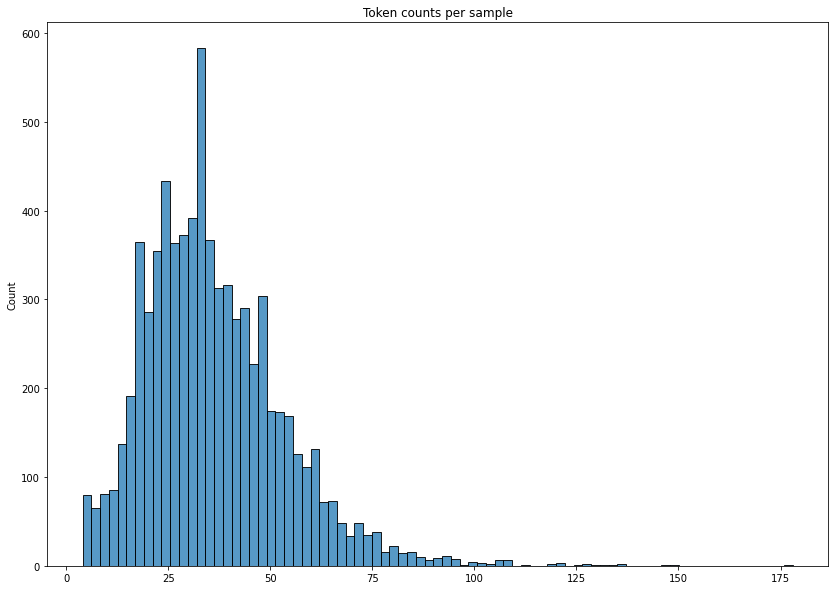

In [5]:
vis_token_counts(lengths)

 * Looks like most sentences are below 100 tokens. Let's be safe and set max length to a little bit more than our outlier (around 175) to 180 tokens 

In [6]:
print(config["tokenizer"]["MAX_LEN"])

180


# Checking how many UNK tokens we have

* Out of curiousity, let's check how many unkown tokens we have (no vocab mapping and can't split into word pieces)
* High amount of UNK tokens may let us want to rethink if we would like to select another tokenization/model approach
* We will be ignoring all data from test set in order to remain as unbiased as we can

In [7]:
print(tokenizer.unk_token_id)

100


In [8]:
n_unk = []
for sent in tokenized_sentences:
    unk_cnt = 0
    for token in sent:
        if token == tokenizer.unk_token_id: unk_cnt += 1
    n_unk.append(unk_cnt)  
print(sum(n_unk))

0


* Hmm, sounds a bit too good to be true lol
* Well, for the sake of time, let's just assume that this is corret, but I would look a little bit more in-depth into this

# Checking target token distribution

In [9]:
encoder = joblib.load("../data/label_encoder.bin")
cnts = defaultdict(lambda  : 0)

for sent_targets in y:
    for s_t in sent_targets:
        cnts[s_t] += 1

total = sum(cnts.values()) 
for k, v in cnts.items():
    print(f"LABEL: {encoder.inverse_transform([k])[0]} | COUNT: {v} | RATIO: {(v/ total):.4f}" )  

LABEL: O | COUNT: 168538 | RATIO: 0.9183
LABEL: B | COUNT: 6704 | RATIO: 0.0365
LABEL: I | COUNT: 8291 | RATIO: 0.0452


* As expected, most tags are tagged with no entity tag
* Since we will be using cross-entropy loss, this may cause some problems as loss may be biased towards majority class (I can't recall whether something in bert architecture or AdamW optimizer adjusts for that)
* However, I did a little exploring at seems that everybody I looked at, including kaggle grandmasters just use standard torches nn.CrossEntropy loss, so I'll just follow their lead :D
* We would try to adjust weights, since torches cross entropy can take in class weights to pay more/less attention to specific classes, but for now let's leave it as it is and see how we do

# Checking for dublicates

* The dataset was taken from the authors of [this](https://arxiv.org/pdf/1901.08746v4.pdf) paper, and they claim that the dublicates have been removed.
* Normally, this is a rather important step and should be performed in most scenarios: we can do a lot of stuff here from simple levenstein distance comparisons, cosine distances between tokens etc. to something more complex like measuring distances between embedded samples, while also adjusting for loss of information by introducing and additional static embedding which will not change while maintaining static embeddings, something similar to what one could see for CNN text classifiers. Well, something like that :D
* we could also think of various techniques to undersample, oversample etc., but will have to figure out what these terms mean for this problem :D